In [1]:
from arraylake import Client
import xarray as xr
import numpy as np

In [2]:
## authentication process

In [3]:
client = Client()

In [4]:
client.login()

🔓 Successfully refreshed tokens!

> Token stored at /home/alfonso/.arraylake/token.json

╭──────────────────────────────────────────────── 👤 User Details ────────────────────────────────────────────────╮
│ Name: Alfonso Ladino-Rincon                                                                                     │
│ Email: alfonso@earthmover.io                                                                                    │
│ Id: c331861f-0725-43ad-85df-7217ef584add                                                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

🔓 Successfully logged in!

> Token stored at /home/alfonso/.arraylake/token.json

╭──────────────────────────────────────────────── 👤 User Details ────────────────────────────────────────────────╮
│ Name: Alfonso Ladino-Rincon                                                                                     │
│ Email: alfonso@earthmover.io                                                                                    │
│ Id: c331861f-0725-43ad-85df-7217ef584add                                                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [5]:
### pointing to the desired repo

In [6]:
repo = client.get_repo("earthmover-demos/nexrad-KVNX")

In [7]:
### creating a new session

In [8]:
session = repo.readonly_session("main")

In [9]:
%%time
dt_radar = xr.open_datatree(
    session.store, engine="zarr", consolidated=False, zarr_format=3, chunks={}
)

CPU times: user 1.95 s, sys: 264 ms, total: 2.21 s
Wall time: 13.3 s


In [10]:
dt_radar["VCP-12/sweep_16"].ds.range.values[-1]

np.float32(116875.0)

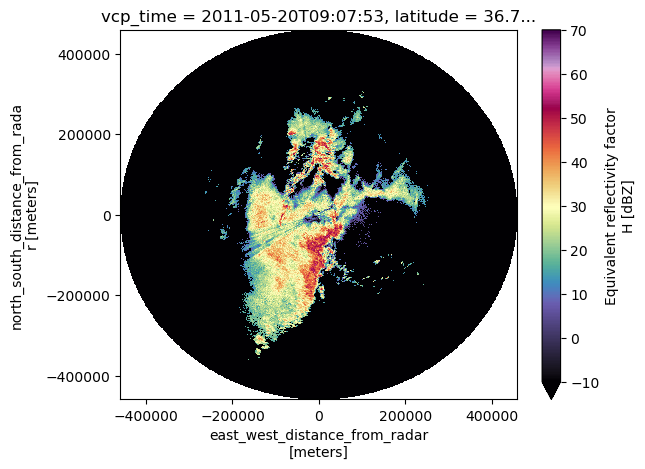

In [11]:
dt_radar["VCP-12/sweep_0/DBZH"].isel(vcp_time=1).plot(
    x="x",
    y="y",
    vmin=-10,
    vmax=70,
    # robust=True,
    cmap="ChaseSpectral",
)

In [12]:
def compute_qvp(ds: xr.Dataset, var="DBZH") -> xr.DataArray:
    """
    Computes a Quasi-Vertical Profile (QVP) from a radar time-series dataset.

    This function averages the specified variable over the azimuthal dimension
    to produce a QVP. If the variable is in dBZ (a logarithmic scale), it converts
    the values to linear units before averaging and then converts the result
    back to dBZ.
    """
    units: str = ds[var].attrs["units"]
    if units.startswith("dB"):
        qvp = 10 ** (ds[var] / 10)
        qvp = qvp.mean("azimuth", skipna=True)
        qvp = 10 * np.log10(qvp)
    else:
        qvp = ds[var]
        qvp = qvp.mean("azimuth", skipna=True)

    # computing heigth dimension
    qvp = qvp.assign_coords(
        {
            "range": (
                qvp.range.values
                * np.sin(ds.sweep_fixed_angle.mean(skipna=True).values * np.pi / 180.0)
            )
            / 1000
        }
    )

    qvp = qvp.rename(f"qvp_{var}")
    qvp = qvp.rename({"range": "height"})
    return qvp

In [13]:
ds_qvp = dt_radar["/VCP-12/sweep_16"].ds.sel(
    vcp_time=slice("2011-05-20 09:45", "2011-05-20 12:15")
)

In [14]:
qvp_ref = compute_qvp(ds_qvp, var="DBZH")

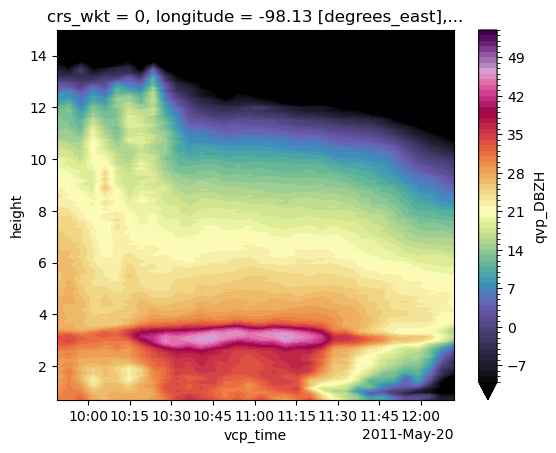

In [15]:
qvp_ref.sel(height=slice(None, 15)).plot.contourf(
    x="vcp_time",
    y="height",
    cmap="ChaseSpectral",
    levels=np.arange(-10, 55, 1),
)

In [16]:
def rain_depth(
    z: xr.DataArray, a: float = 200.0, b: float = 1.6, t: int = 5
) -> xr.DataArray:
    """
    Estimates rainfall depth using radar reflectivity and a Z-R relationship.

    This function computes Quantitative Precipitation Estimation (QPE) by converting
    radar reflectivity (Z) into rainfall rate (R) using the Z-R relationship and
    then integrating over time to estimate the total rainfall depth.

    Parameters:
    -----------
    z : xr.DataArray
        Radar reflectivity in dBZ. This should be a multi-dimensional Xarray DataArray.
    a : float, optional
        The alpha (a) parameter in the Z-R relationship. Default is 200.0, corresponding
        to the Marshall and Palmer (1948) relationship.
    b : float, optional
        The beta (b) parameter in the Z-R relationship. Default is 1.6, also from the
        Marshall and Palmer (1948) relationship.
    t : int, optional
        Time integration period in minutes, used to convert rainfall rates into
        accumulated depth. Default is 5 minutes.

    Returns:
    --------
    xr.DataArray
        A DataArray representing the estimated rainfall depth in the same dimensions
        as the input radar reflectivity. The units of the returned DataArray will be
        consistent with the time integration provided (e.g., mm for 5-minute accumulation).

    Notes:
    ------
    - The Z-R relationship used is of the form Z = a * R^b, where Z is in linear units.
    - The function first converts the radar reflectivity from dBZ to linear units (Z),
      then computes the rainfall rate (R), and finally multiplies by the time integration
      period to obtain the rainfall depth.

    Example:
    --------
    To compute the rainfall depth over a 5-minute period using reflectivity data:

    >>> rainfall_depth = rain_depth(z, a=200.0, b=1.6, t=5)

    This will return the estimated rainfall depth in millimeters, assuming the default
    parameters for the Marshall and Palmer (1955) Z-R relationship.

    """
    # Convert reflectivity from dBZ to linear units
    z_lin = 10 ** (z / 10)
    # Compute rainfall depth using the Z-R relationship and time integration

    return ((1 / a) ** (1 / b) * z_lin ** (1 / b)) * (t / 60)  # rainfall depth

In [17]:
# Reflectividad en unidades decibelicas
ref_log = dt_radar["VCP-12/sweep_0"].DBZH
# rainfall depth
rr = rain_depth(ref_log)

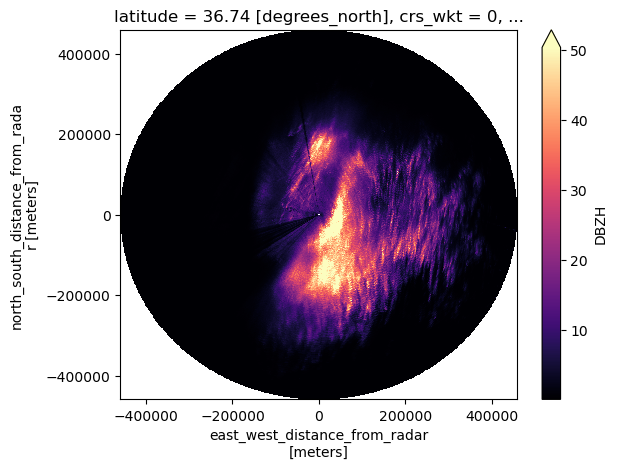

In [18]:
rr.sum("vcp_time").plot(x="x", y="y", cmap="magma", robust=True)